In [1]:
import os
dataset_path = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'
image_paths = [os.path.join(dataset_path,file) for file in os.listdir(dataset_path)]


In [2]:
import tensorflow as tf

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - 0.5) / 0.5  # Normalize to [-1, 1]
    return image

2025-08-17 17:38:33.634889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755452313.817622      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755452313.870908      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import tensorflow as tf
path_slices = tf.data.Dataset.from_tensor_slices(image_paths)

dataset = (
    path_slices
    .shuffle(buffer_size=len(image_paths))   # Shuffle the dataset
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

I0000 00:00:1755452327.060772      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755452327.061552      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
import tensorflow as tf
from tensorflow.keras import layers

class Generator(tf.keras.Model):  
    def __init__(self, z_dim=100, img_channels=3):
        super(Generator,self).__init__()
        self.fc1 = layers.Dense(256, activation='relu')
        self.fc2 = layers.Dense(512, activation='relu')
        self.fc3 = layers.Dense(1024, activation='relu')
       
        self.fc4 = layers.Dense(img_channels * 64 * 64, activation='tanh')
        self.img_channels = img_channels

    def call(self, z):   
        x = self.fc1(z)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        img = tf.reshape(x, (-1, 64, 64, self.img_channels))
        return img


In [5]:
import tensorflow as tf
from tensorflow.keras import layers

class Discriminator(tf.keras.Model):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()

        self.flatten = layers.Flatten()

        self.fc1 = layers.Dense(1024)
        self.lrelu1 = layers.LeakyReLU(alpha=0.2)

        self.fc2 = layers.Dense(512)
        self.lrelu2 = layers.LeakyReLU(alpha=0.2)

        self.fc3 = layers.Dense(256)
        self.lrelu3 = layers.LeakyReLU(alpha=0.2)

        self.fc4 = layers.Dense(1, activation='sigmoid')  # final output: probability

    def call(self, img):
        x = self.flatten(img)

        x = self.fc1(x)
        x = self.lrelu1(x)

        x = self.fc2(x)
        x = self.lrelu2(x)

        x = self.fc3(x)
        x = self.lrelu3(x)

        out = self.fc4(x)  
        return out


In [6]:
import tensorflow as tf


adversarial_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)


generator = Generator(z_dim=100)
discriminator = Discriminator()


optimizer_G = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
optimizer_D = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"


with tf.device(device):
    generator.build((None, 100))  # build model with input shape
    discriminator.build((None, 64, 64, 3))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'generator', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'discriminator', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` me

In [7]:
import tensorflow as tf

# Training loop
def train(generator, discriminator, dataset, epochs=5, z_dim=100):
    for epoch in range(epochs):
        for i, real_imgs in enumerate(dataset):
            batch_size = tf.shape(real_imgs)[0]

            # Labels
            valid = tf.ones((batch_size, 1))   # real = 1
            fake = tf.zeros((batch_size, 1))   # fake = 0

            # ----------------------
            # Train Discriminator
            # ----------------------
            noise = tf.random.normal((batch_size, z_dim))  # latent vector

            with tf.GradientTape() as tape_D:
                # Predictions on real and fake images
                real_pred = discriminator(real_imgs, training=True)
                fake_imgs = generator(noise, training=True)
                fake_pred = discriminator(fake_imgs, training=True)

                # Loss
                real_loss = adversarial_loss(valid, real_pred)
                fake_loss = adversarial_loss(fake, fake_pred)
                d_loss = (real_loss + fake_loss) / 2

            grads_D = tape_D.gradient(d_loss, discriminator.trainable_variables)
            optimizer_D.apply_gradients(zip(grads_D, discriminator.trainable_variables))

            # ----------------------
            # Train Generator
            # ----------------------
            noise = tf.random.normal((batch_size, z_dim))

            with tf.GradientTape() as tape_G:
                fake_imgs = generator(noise, training=True)
                fake_pred = discriminator(fake_imgs, training=True)

                # Generator wants discriminator to predict all ones
                g_loss = adversarial_loss(valid, fake_pred)

            grads_G = tape_G.gradient(g_loss, generator.trainable_variables)
            optimizer_G.apply_gradients(zip(grads_G, generator.trainable_variables))

            # ----------------------
            # Print progress
            # ----------------------
            if i % 50 == 0:
                print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}] "
                      f"[D loss: {d_loss.numpy():.4f}] [G loss: {g_loss.numpy():.4f}]")


In [8]:
train(generator,discriminator,dataset)

[Epoch 5/5] [Batch 2200] [D loss: 0.6284] [G loss: 0.8401]
[Epoch 5/5] [Batch 2250] [D loss: 0.6462] [G loss: 0.9377]
[Epoch 5/5] [Batch 2300] [D loss: 0.6485] [G loss: 0.8434]
[Epoch 5/5] [Batch 2350] [D loss: 0.6550] [G loss: 0.9108]
[Epoch 5/5] [Batch 2400] [D loss: 0.6985] [G loss: 0.8550]
[Epoch 5/5] [Batch 2450] [D loss: 0.6039] [G loss: 0.8734]
[Epoch 5/5] [Batch 2500] [D loss: 0.7278] [G loss: 0.7294]
[Epoch 5/5] [Batch 2550] [D loss: 0.7007] [G loss: 0.9512]
[Epoch 5/5] [Batch 2600] [D loss: 0.6260] [G loss: 0.8656]
[Epoch 5/5] [Batch 2650] [D loss: 0.6692] [G loss: 0.8447]
[Epoch 5/5] [Batch 2700] [D loss: 0.6501] [G loss: 0.9456]
[Epoch 5/5] [Batch 2750] [D loss: 0.6341] [G loss: 0.6983]
[Epoch 5/5] [Batch 2800] [D loss: 0.6307] [G loss: 0.8754]
[Epoch 5/5] [Batch 2850] [D loss: 0.6100] [G loss: 0.8099]
[Epoch 5/5] [Batch 2900] [D loss: 0.6121] [G loss: 1.0371]
[Epoch 5/5] [Batch 2950] [D loss: 0.6779] [G loss: 0.7815]
[Epoch 5/5] [Batch 3000] [D loss: 0.6938] [G loss: 1.027

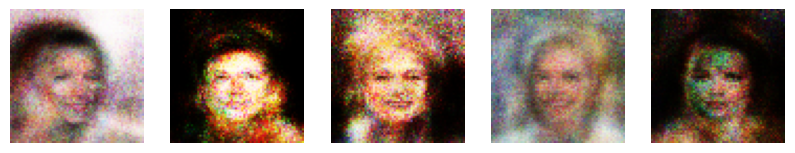

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to generate and display fake images
def generate_and_show_images(generator, num_images=5, noise_dim=100):
    # 1️⃣ Generate random noise
    noise = tf.random.normal([num_images, noise_dim])
    
    # 2️⃣ Use generator to create fake images
    fake_images = generator(noise, training=False)

    # 3️⃣ Rescale images from [-1, 1] to [0, 1] if needed
    fake_images = (fake_images + 1) / 2.0

    # 4️⃣ Plot the images
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(fake_images[i])
        plt.axis("off")
    plt.show()


# Example usage after training
# train(generator, discriminator, dataset, epochs=5)
generate_and_show_images(generator, num_images=5, noise_dim=100)
